In [1]:
!pip install numpy pandas music21 matplotlib seaborn torch torchvision

import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from music21 import converter, instrument, note, chord, stream
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from music21 import environment

# Set the MuseScore paths in the music21 environment
env = environment.UserSettings()
env['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 4/bin/MuseScore4.exe'
env['musicxmlPath'] = 'C:/Program Files/MuseScore 4/bin/MuseScore4.exe'

# Set MIDI file directory
#Extract all midi files from different folders into the "archive" folder in directory
filepath = "./archive" 

# Function to extract notes from MIDI files
def extract_notes(midi_folder):
    notes = []
    for file in os.listdir(midi_folder):
        if file.endswith(".mid"):
            try:
                midi_path = os.path.join(midi_folder, file)
                midi = converter.parse(midi_path)
            except Exception as e:
                print(f"Error processing {file}: {e}")
            notes_to_parse = None
            try:  # file has instrument parts
                s2 = instrument.partitionByInstrument(midi)
                notes_to_parse = s2.parts[0].recurse()
            except:  # file has notes in a flat structure
                notes_to_parse = midi.flat.notes
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
    return notes


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: c:\users\user\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip


In [5]:

# Extract notes from MIDI files
all_notes = extract_notes(filepath)

# Prepare sequential data for Transformer
n_vocab = len(set(all_notes))
sequence_length = 100

# Create a dictionary to convert notes to integers
note_to_int = dict((note, number) for number, note in enumerate(set(all_notes)))

network_input = []
network_output = []

# Create input sequences and the corresponding outputs
for i in range(0, len(all_notes) - sequence_length, 1):
    sequence_in = all_notes[i:i + sequence_length]
    sequence_out = all_notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

# Reshape the input into a format compatible with Transformer layers
network_input = np.reshape(network_input, (n_patterns, sequence_length))
# Normalize input
network_input = network_input / float(n_vocab)

network_output = pd.get_dummies(network_output).values

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(network_input, network_output, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Custom Dataset class
class MIDIDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader for training and validation
train_dataset = MIDIDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = MIDIDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [3]:
# Custom Positional Encoding
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [4]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])
        return output


# Create the Transformer neural network
input_dim = 1
d_model = 512
nhead = 8
num_encoder_layers = 3
dim_feedforward = 2048
output_dim = n_vocab

model = TransformerModel(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, output_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.01)

# Training the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(-1)  
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}')
    return train_losses

train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=20)
torch.save(model.state_dict(), 'transformer_model.pth')

Epoch 1/20, Loss: 4.9603765047699815
Epoch 2/20, Loss: 4.818298451841281
Epoch 3/20, Loss: 4.821510951755816
Epoch 4/20, Loss: 4.817262882088431
Epoch 5/20, Loss: 4.820186033367303
Epoch 6/20, Loss: 4.820040349874216
Epoch 7/20, Loss: 4.823877643570135
Epoch 8/20, Loss: 4.817311479168067
Epoch 9/20, Loss: 4.820051478935956
Epoch 10/20, Loss: 4.822415125370026
Epoch 11/20, Loss: 4.819937846569122
Epoch 12/20, Loss: 4.8188975015558455
Epoch 13/20, Loss: 4.814766785926259
Epoch 14/20, Loss: 4.814562765039655
Epoch 15/20, Loss: 4.8171014323729695
Epoch 16/20, Loss: 4.81556366542123
Epoch 17/20, Loss: 4.814476097356654
Epoch 18/20, Loss: 4.81407933732995
Epoch 19/20, Loss: 4.808325823435127
Epoch 20/20, Loss: 4.812697091167183


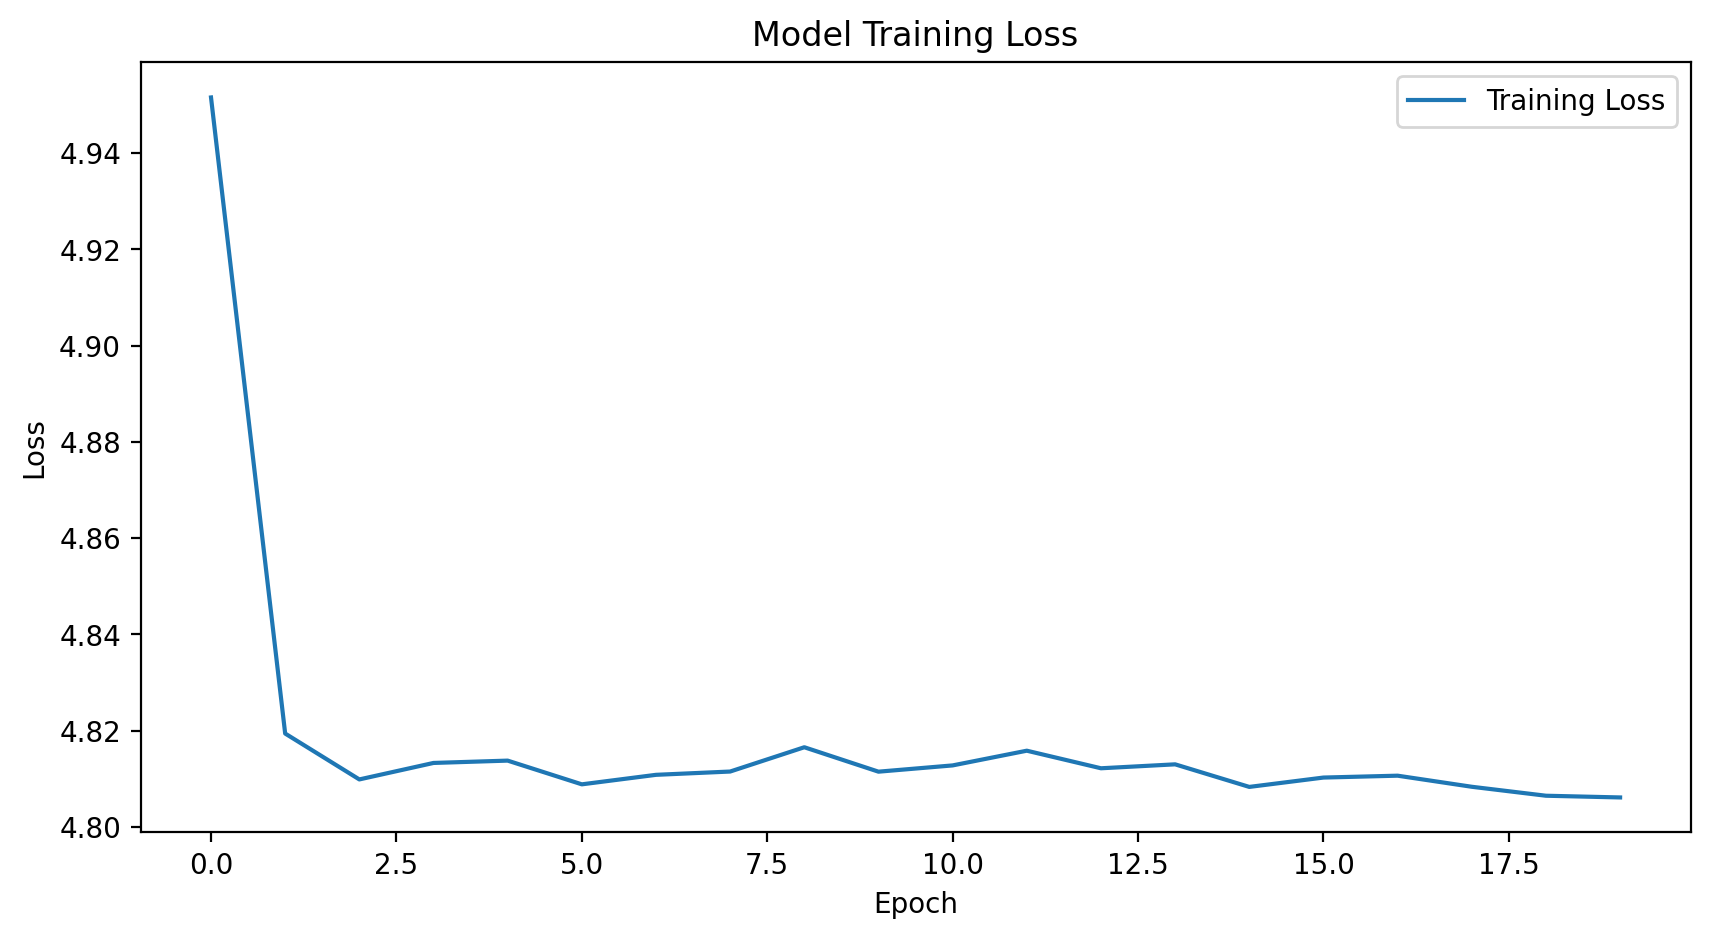

In [14]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Function to generate music notes from the model
def generate_notes(model, network_input, n_vocab, sequence_length=100, num_notes=500):
    # Start with a random sequence from the input
    start = np.random.randint(0, len(network_input)-1)
    int_to_note = dict((number, note) for number, note in enumerate(set(all_notes)))
    pattern = network_input[start]
    prediction_output = []

    # Generate notes
    model.eval()
    with torch.no_grad():
        for note_index in range(num_notes):
            prediction_input = torch.tensor(pattern.reshape(1, sequence_length)).float()
            output = model(prediction_input.unsqueeze(-1))
            index = torch.argmax(output, dim=1).item()

            result = int_to_note[index]
            prediction_output.append(result)

            pattern = np.append(pattern[1:], index / float(n_vocab))

    return prediction_output

prediction_output = generate_notes(model, network_input, n_vocab)

# Convert the output to a MIDI file
offset = 0
output_notes = []

for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # Increase offset each iteration so notes do not stack
    offset += 0.5

midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='transformer_output.midi')

'transformer_output.midi'